In [1]:
import numpy as np
import pandas as pd
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
class X_BrainNet_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(X_BrainNet_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

In [29]:
train_df = pd.read_csv(r'dataset/emotiv/train_real_data_a_b_c.csv')
train_df = train_df.drop(columns=['User'])

In [30]:
val_df = pd.read_csv(r'dataset/emotiv/val_real_data_d.csv')
val_df = val_df.drop(columns=['User'])

In [35]:
X = train_df.iloc[:, 1:].values
Y = train_df.iloc[:, 0].values
unique_labels = set(Y)
if unique_labels != {0, 1}:
    print("Warning: Labels are not binary. Adjusting them to binary values.")
    Y = (Y != 0).astype(int)

In [36]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X_normalized)
Y_tensor = torch.FloatTensor(Y.reshape(-1, 1))

In [37]:
train_dataset = TensorDataset(X_tensor, Y_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

In [38]:
X = val_df.iloc[:, 1:].values
Y = val_df.iloc[:, 0].values
unique_labels = set(Y)
if unique_labels != {0, 1}:
    print("Warning: Labels are not binary. Adjusting them to binary values.")
    Y = (Y != 0).astype(int)

In [39]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X_normalized)
Y_tensor = torch.FloatTensor(Y.reshape(-1, 1))

In [40]:
test_dataset = TensorDataset(X_tensor, Y_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [41]:
model = X_BrainNet_LSTM(input_size=112, hidden_size=8, num_layers=2, num_classes=1, dropout_rate=0.3)

In [42]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
epochs = 100
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
precisions, recalls = [], []

In [43]:
#Training
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    y_true_train, y_pred_train = [], []
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        predictions = outputs.round()
        accuracy = (predictions == labels).float().mean()
        total_train_accuracy += accuracy.item()
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        y_true_train.extend(labels.view(-1).tolist())
        y_pred_train.extend(predictions.view(-1).tolist())
    
    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    
    # Evaluation
    model.eval()
    total_test_loss = 0
    total_test_accuracy = 0
    y_true_test, y_pred_test = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            predictions = outputs.round()
            accuracy = (predictions == labels).float().mean()
            total_test_accuracy += accuracy.item()
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
    
            y_true_test.extend(labels.view(-1).tolist())
            y_pred_test.extend(predictions.view(-1).tolist())
    
    avg_test_loss = total_test_loss / len(test_loader)
    avg_test_accuracy = total_test_accuracy / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracies.append(avg_test_accuracy)
    
    # Calculate precision and recall
    precision = precision_score(y_true_test, y_pred_test)
    recall = recall_score(y_true_test, y_pred_test)
    precisions.append(precision)
    recalls.append(recall)
    
    print(
        f"Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Epoch 0: Train Loss: 0.6407, Train Accuracy: 0.6667, Test Loss: 0.6395, Test Accuracy: 0.6667, Precision: 0.6667, Recall: 1.0000
Epoch 1: Train Loss: 0.6051, Train Accuracy: 0.6757, Test Loss: 0.6434, Test Accuracy: 0.6670, Precision: 0.6787, Recall: 0.9505
Epoch 2: Train Loss: 0.5708, Train Accuracy: 0.7097, Test Loss: 0.6748, Test Accuracy: 0.5816, Precision: 0.6873, Recall: 0.6833
Epoch 3: Train Loss: 0.5294, Train Accuracy: 0.7360, Test Loss: 0.7303, Test Accuracy: 0.5417, Precision: 0.6868, Recall: 0.5745
Epoch 4: Train Loss: 0.4901, Train Accuracy: 0.7659, Test Loss: 0.8102, Test Accuracy: 0.5229, Precision: 0.6855, Recall: 0.5255
Epoch 5: Train Loss: 0.4583, Train Accuracy: 0.7854, Test Loss: 0.8968, Test Accuracy: 0.5083, Precision: 0.6800, Recall: 0.4958
Epoch 6: Train Loss: 0.4272, Train Accuracy: 0.8061, Test Loss: 1.0264, Test Accuracy: 0.4872, Precision: 0.6700, Recall: 0.4547
Epoch 7: Train Loss: 0.4039, Train Accuracy: 0.8236, Test Loss: 1.1484, Test Accuracy: 0.4795, Pr

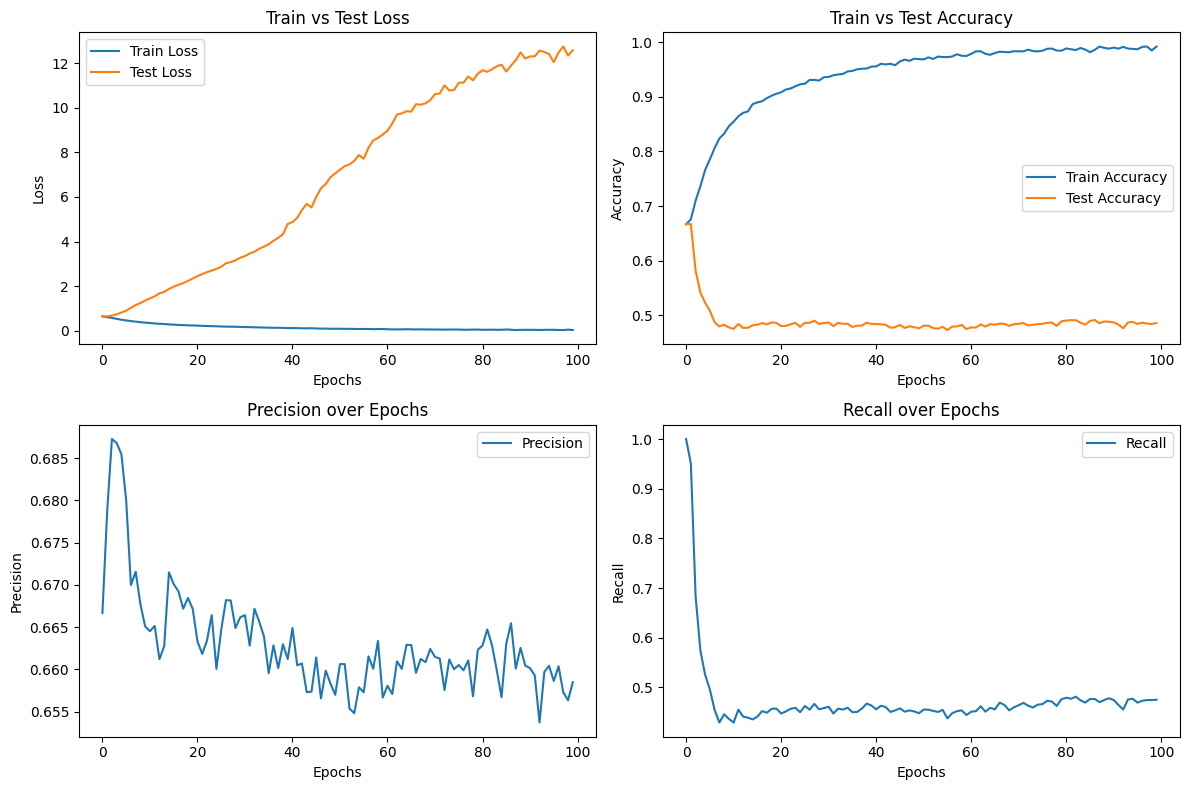

In [44]:
# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(precisions, label='Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(recalls, label='Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
# Training using synthetic and real data 

In [49]:
train_df = pd.read_csv(r"dataset/emotiv/Dataset/synthetic/real_and_vae_synthetic_from_A_B_C_Version_100.csv")
train_df = train_df.drop(columns=['User'])

In [50]:
X = train_df.iloc[:, 1:].values
Y = train_df.iloc[:, 0].values
unique_labels = set(Y)
if unique_labels != {0, 1}:
    print("Warning: Labels are not binary. Adjusting them to binary values.")
    Y = (Y != 0).astype(int)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X_normalized)
Y_tensor = torch.FloatTensor(Y.reshape(-1, 1))


train_dataset = TensorDataset(X_tensor, Y_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)



In [53]:
val_df = pd.read_csv(r'dataset/emotiv/val_real_data_d.csv') #Using real data for validation 
val_df = val_df.drop(columns=['User'])

In [54]:
X = val_df.iloc[:, 1:].values
Y = val_df.iloc[:, 0].values
unique_labels = set(Y)
if unique_labels != {0, 1}:
    print("Warning: Labels are not binary. Adjusting them to binary values.")
    Y = (Y != 0).astype(int)
    
    
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X_normalized)
Y_tensor = torch.FloatTensor(Y.reshape(-1, 1))


test_dataset = TensorDataset(X_tensor, Y_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [55]:
model = X_BrainNet_LSTM(input_size=112, hidden_size=8, num_layers=2, num_classes=1, dropout_rate=0.3)


In [56]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
epochs = 100
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
precisions, recalls = [], []

In [57]:
#Training
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    y_true_train, y_pred_train = [], []
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        predictions = outputs.round()
        accuracy = (predictions == labels).float().mean()
        total_train_accuracy += accuracy.item()
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        y_true_train.extend(labels.view(-1).tolist())
        y_pred_train.extend(predictions.view(-1).tolist())
    
    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    
    # Evaluation
    model.eval()
    total_test_loss = 0
    total_test_accuracy = 0
    y_true_test, y_pred_test = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            predictions = outputs.round()
            accuracy = (predictions == labels).float().mean()
            total_test_accuracy += accuracy.item()
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
    
            y_true_test.extend(labels.view(-1).tolist())
            y_pred_test.extend(predictions.view(-1).tolist())
    
    avg_test_loss = total_test_loss / len(test_loader)
    avg_test_accuracy = total_test_accuracy / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracies.append(avg_test_accuracy)
    
    # Calculate precision and recall
    precision = precision_score(y_true_test, y_pred_test)
    recall = recall_score(y_true_test, y_pred_test)
    precisions.append(precision)
    recalls.append(recall)
    
    print(
        f"Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Epoch 0: Train Loss: 0.6358, Train Accuracy: 0.6658, Test Loss: 0.6336, Test Accuracy: 0.6691, Precision: 0.6684, Recall: 0.9995
Epoch 1: Train Loss: 0.6148, Train Accuracy: 0.6794, Test Loss: 0.6175, Test Accuracy: 0.6767, Precision: 0.7073, Recall: 0.8786
Epoch 2: Train Loss: 0.5911, Train Accuracy: 0.6986, Test Loss: 0.6127, Test Accuracy: 0.6663, Precision: 0.7396, Recall: 0.7708
Epoch 3: Train Loss: 0.5689, Train Accuracy: 0.7128, Test Loss: 0.6436, Test Accuracy: 0.6288, Precision: 0.7641, Recall: 0.6411
Epoch 4: Train Loss: 0.5474, Train Accuracy: 0.7287, Test Loss: 0.6791, Test Accuracy: 0.6212, Precision: 0.7776, Recall: 0.6047
Epoch 5: Train Loss: 0.5299, Train Accuracy: 0.7393, Test Loss: 0.7132, Test Accuracy: 0.6205, Precision: 0.7719, Recall: 0.6115
Epoch 6: Train Loss: 0.5163, Train Accuracy: 0.7465, Test Loss: 0.7271, Test Accuracy: 0.6212, Precision: 0.7676, Recall: 0.6193
Epoch 7: Train Loss: 0.5022, Train Accuracy: 0.7555, Test Loss: 0.7731, Test Accuracy: 0.6160, Pr

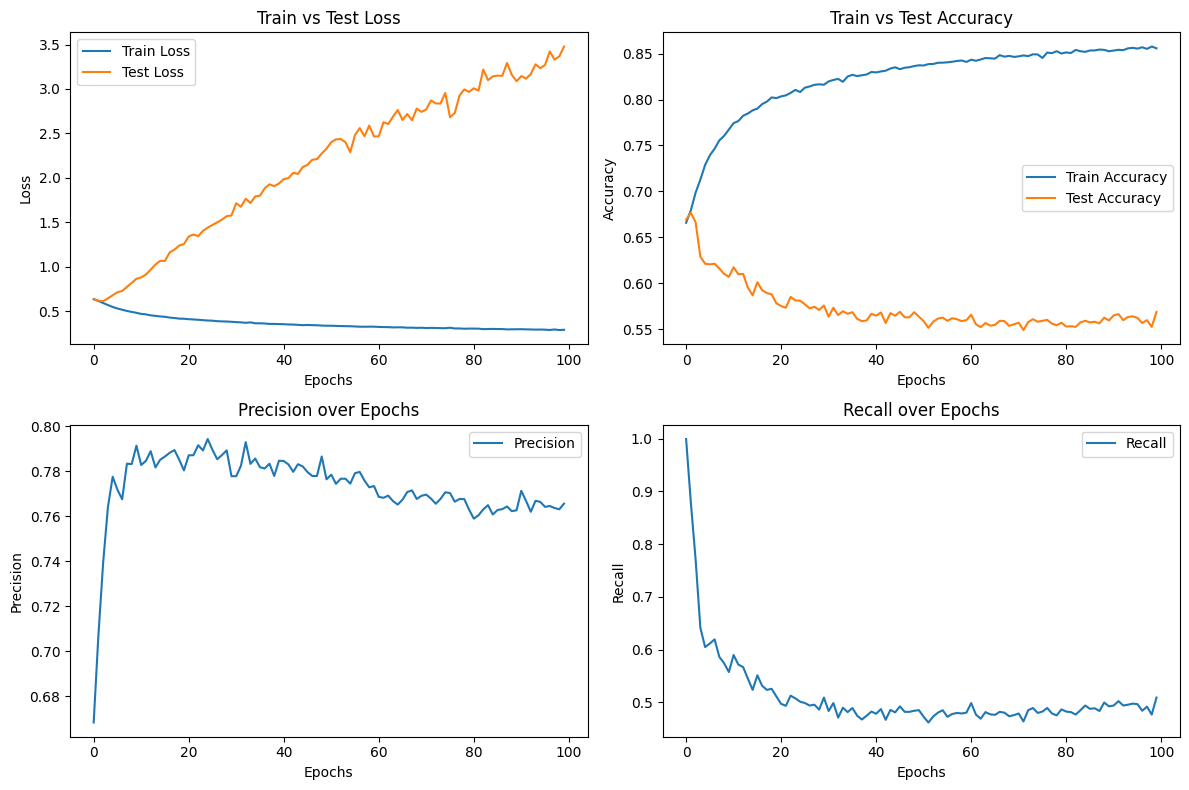

In [58]:
# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(precisions, label='Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(recalls, label='Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()